# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify ~~all symbols~~ letters a -> g

### Subset the data

Select only the lowercase letters (a, b, ..., g) for classification

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 3. Model showdown: upper vs lowercase on abcXYZ

### Subset the data

Select out the set of upper- and lowercase (a, b, c, x, y z, A, B, C, X, Y, Z). Note that some of these classes can be confusing (e.g., x and y).

### Train and tune models

Perform a full model training and hyperparameter tuning.

1. Select candidate models, hyperparameter options, and evaluation metric
2. Set aside a validation hold-out dataset
3. Train models over K splits (use k-fold or train/test split)
    1. Split train using k-fold with the number of folds equal to the number of parameter combinations
    2. Train on k-fold split
    3. Record performance of each set of parameters
    4. Use winning set of parameters to train model on full training set
    5. Record each model's performance on that split's test set
4. Evaluate model performance and promote one model as the winner
5. Train winning model on both train + test
6. Check model performance on the validation hold-out


## 4. (_Optional_) Model comparison: classify even vs odd

**NOTE:** This is a larger dataset (~400k rows) so it will require more memory and time to train models on it. 

Alternatively, you can train models on smaller subsets of the data to get a feel for which models perform better than others. Then train the winning model on the full dataset and validate against the hold-out.

### Subset the data

Select only digits and add a column for 'is_even'. Be sure to create a validation hold-out dataset for later.

### Build and compare models

Train at least two different models, compare the results and choose a winner based on an evaluation metric of your choice.

In [1]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown

# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28

In [142]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Modified to display heatmap for multiclass
def display_metrics(task, model_name, metrics_dict,labels):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if not isinstance(value, np.ndarray):
            metrics_df[key] = [value]

    cm = metrics_dict[task][model_name]['confusion_matrix']
    cm_df = pd.DataFrame(cm / cm.sum(axis=1)[:, np.newaxis])
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=False, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    # Customize axis labels
    plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
    plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
    plt.show()
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
#[str(i) if i < 10 else chr(i - 10 + ord('A')) if i < 36 else chr(i - 36 + ord('a')) for i in range(62)]

In [3]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
emnist_train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
emnist_train['image'] = list(image)
emnist_train['image_flat'] = emnist_train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
emnist_train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
emnist_train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
emnist_test = pd.DataFrame()
emnist_test['image'] = list(image)
emnist_test['image_flat'] = emnist_test['image'].apply(lambda x: np.array(x).reshape(-1))
emnist_test['label'] = label
emnist_test['class'] = class_label

# Combine the training and test splits
emnist_all = pd.concat([emnist_train, emnist_test], axis=0)

# Subset for only digits 0-9
digits = emnist_all[emnist_all['label'] < 10]

# Subset for lowercase letters
lowercase = emnist_all[(emnist_all['class'] >= 'a') & (emnist_all['class'] <= 'z')]
uppercase = emnist_all[(emnist_all['class'] >= 'A') & (emnist_all['class'] <= 'Z')]

# Subset for upper- and lowercase letters a, b, c, d, e, f, g
a2g = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'd', 'e', 'f', 'g']))]

# Subset for upper- and lowercase letters a, b, c, x, y, z
abcxyz = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'A', 'B', 'C', \
                                               'x', 'y', 'z', 'X', 'Y', 'Z']))]

In [4]:
# Display the size of a2g, abcxyz, digits, and the full dataset
display(Markdown(f'# Dataset Sizes'))
display(Markdown(f'**a2g**: {len(a2g)}'))
display(Markdown(f'**abcxyz**: {len(abcxyz)}'))
display(Markdown(f'**digits**: {len(digits)}'))
display(Markdown(f'**emnist_all**: {len(emnist_all)}'))

# Dataset Sizes

**a2g**: 68795

**abcxyz**: 65926

**digits**: 402953

**emnist_all**: 814255

In [20]:
# Classify lettters as uppercase/lowercase
abcxyz['is_upper'] = abcxyz['class'].str.isupper()

# Classify digits as even/odd
digits['is_even'] = digits['class'].astype(int) % 2 == 0

/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_83878/2920331779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abcxyz['is_upper'] = abcxyz['class'].str.isupper()
/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_83878/2920331779.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  digits['is_even'] = digits['class'].astype(int) % 2 == 0


# a-g classification

In [31]:
 
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier
# Constants
SIZE = 28
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings


In [162]:
# Split into train and test 

from sklearn.model_selection import train_test_split
 
random_seed = 42
train, test = train_test_split(a2g, test_size=0.1, stratify=a2g['label'], random_state=random_seed)
 
task = 'multi-class'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)
label_dict = dict(zip(train['label'].unique(),np.arange(7)))
# Convert data to tensor
train_images = np.array(train['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train['label'].map(label_dict))
test_images = np.array(test['image'])
test_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), test_images)))
test_images = test_images / 255.0
test_labels = np.array(test['label'].map(label_dict))
# Convert labels to one-hot encoding
train_labels_onehot = to_categorical(train_labels, num_classes=7)
test_labels_onehot = to_categorical(test_labels, num_classes=7)
 

In [164]:
# Choose model - cnn

# Initialize neural network model
# Initialize convolutional neural network model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])


# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels_onehot, epochs=20, validation_data=(test_images, test_labels_onehot))

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels_onehot) 
y_pred = np.argmax(model.predict(test_images), axis=-1)


Epoch 1/20
1935/1935 [==============================] - 35s 18ms/step - loss: 0.1456 - accuracy: 0.9553 - val_loss: 0.0871 - val_accuracy: 0.9741
Epoch 2/20
1935/1935 [==============================] - 25s 13ms/step - loss: 0.0672 - accuracy: 0.9800 - val_loss: 0.0687 - val_accuracy: 0.9798
Epoch 3/20
1935/1935 [==============================] - 25s 13ms/step - loss: 0.0500 - accuracy: 0.9853 - val_loss: 0.0657 - val_accuracy: 0.9817
Epoch 4/20
1935/1935 [==============================] - 24s 12ms/step - loss: 0.0395 - accuracy: 0.9881 - val_loss: 0.0652 - val_accuracy: 0.9820
Epoch 5/20
1935/1935 [==============================] - 26s 13ms/step - loss: 0.0304 - accuracy: 0.9909 - val_loss: 0.0680 - val_accuracy: 0.9839
Epoch 6/20
1935/1935 [==============================] - 24s 13ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.0661 - val_accuracy: 0.9836
Epoch 7/20
1935/1935 [==============================] - 24s 12ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.0740 -

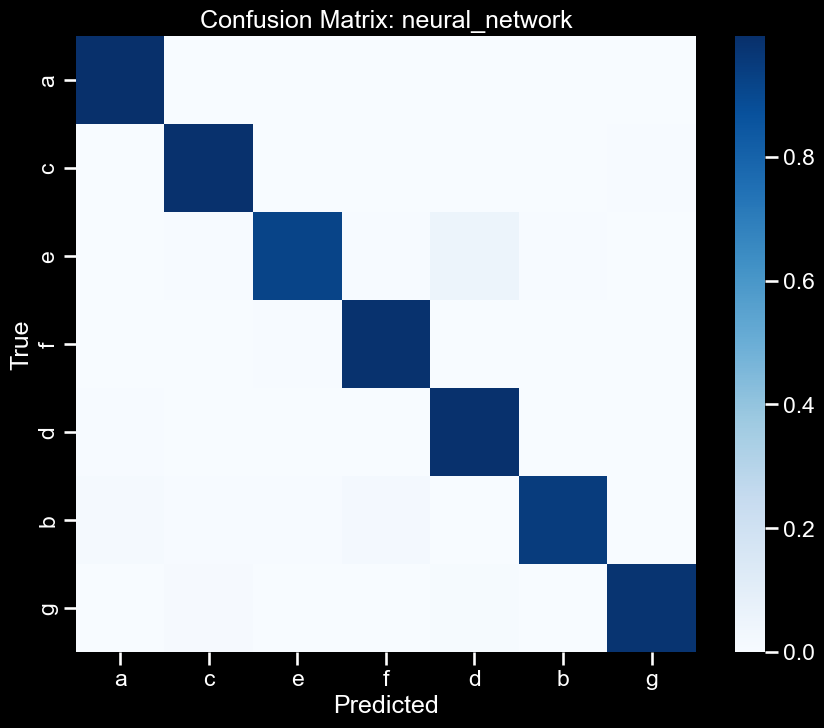

# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.983576,0.976374,0.971776,0.973905


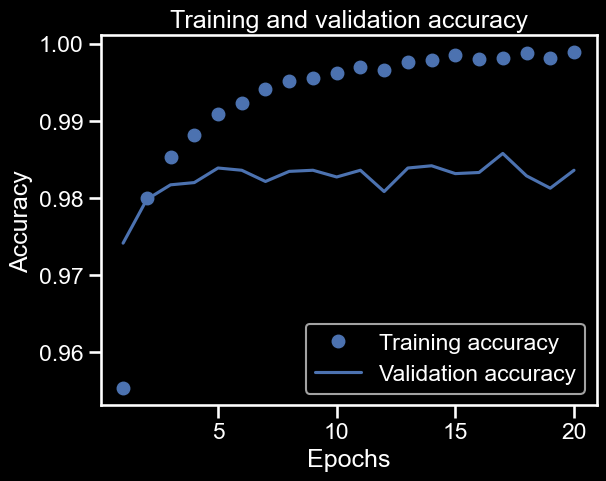

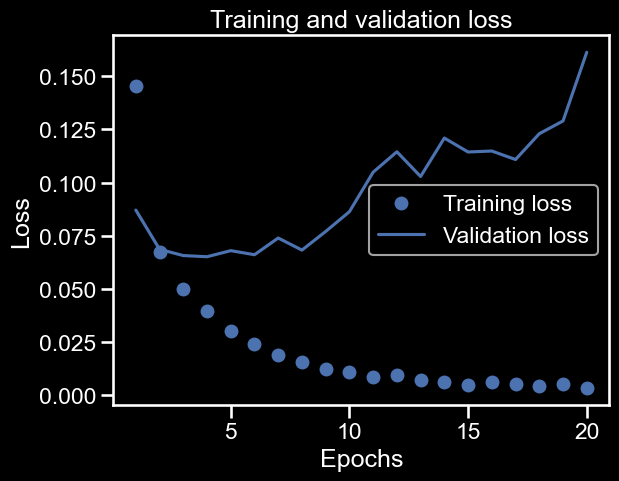

In [165]:
# (OPTIONAL) We can define all the metrics we want to track in a dictionary
metrics_dict = {
    'multi-class' : { # task name (0 vs 1 classifier) 
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}
# Calculate performance metrics
prec = precision_score(test_labels, y_pred, average='macro')
rec = recall_score(test_labels, y_pred, average='macro')
f1 = f1_score(test_labels, y_pred, average='macro')
cm = confusion_matrix(test_labels, y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}
# confusion matrix
display_metrics(task, model_name, metrics_dict,labels=a2g['class'].unique())
# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

# abcXYZ classification (binary)

In [149]:
from sklearn.ensemble import  GradientBoostingClassifier


In [166]:
# (OPTIONAL) We can define all the metrics we want to track in a dictionary
metrics_dict = {
    'bianry' : { # task name (0 vs 1 classifier)
        'gradientboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [172]:
train, valid = train_test_split(abcxyz, test_size=0.1, stratify=abcxyz['is_upper'], random_state=random_seed)
X_train = train['image_flat'].tolist()
y_train = train['is_upper']
X_valid = valid['image_flat'].tolist()
y_valid = valid['is_upper'] 


In [244]:
# Hyperparameter tuning maximizing accuracy.  
# define models
models = {
    'random_forest': RandomForestClassifier(random_state=42),
    'xgboost': XGBClassifier(objective='binary:logistic', random_state=42)
}

In [224]:
from sklearn.model_selection import StratifiedKFold  
import itertools

In [226]:
# Set hyperparameter options
hyperparameters = {
    'n_estimators': [50, 100],
    'max_depth': [3, 7]
}

# Evaluation metric
evaluation_metric = accuracy_score

k_folds = 4
kf = StratifiedKFold(n_splits=k_folds) 
# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*hyperparameters.values()))


In [ ]:

# Dictionary to store performance metrics for each model
model_performance = {}

# Train and tune models
for model_name, model in models.items():
    print("Training and tuning ", model_name)
    best_score = 0
    best_params = None
    
    for params in param_combinations:
        model.set_params(**{param_name: param_value for param_name, param_value in zip(hyperparameters.keys(), params)})
        
        # Cross-validation loop
        fold_scores = []
        for i, (train_index, test_index) in enumerate(kf.split(train, train['is_upper'])):
            print(f"fold {i}") 
            X_train_fold = [train['image_flat'].values[i] for i in train_index]
            X_test_fold = [train['image_flat'].values[i] for i in test_index] 
            y_train_fold = [train['is_upper'].values[i] for i in train_index]
            y_test_fold = [train['is_upper'].values[i] for i in test_index] 
            model.fit(X_train_fold, y_train_fold)
            y_pred_fold = model.predict(X_test_fold)
            fold_scores.append(evaluation_metric(y_test_fold, y_pred_fold))
        
        avg_score = sum(fold_scores) / len(fold_scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = params
            best_fold_scores = fold_scores
    
    # Train winning model on full training set
    #model.set_params(**{param_name: param_value for param_name, param_value in zip(hyperparameters.keys(), best_params)})
    #model.fit(X_train, y_train)
  
    model_performance[model_name] = {'best_params': dict(zip(hyperparameters.keys(), best_params)), 'best_score': best_fold_scores}


In [242]:

# Print best fold score corresponding to each parameter combination
for model_name, params_info in model_performance.items():
    print("Model:", model_name)
    print("Best param: ", params_info['best_params'])
    print("Best score: ",np.mean( params_info['best_fold_scores']))
    
    

Model: random_forest
Best param:  {'n_estimators': 100, 'max_depth': 7}
Best score:  0.8088584444726362
Model: xgboost
Best param:  {'n_estimators': 100, 'max_depth': 7}
Best score:  0.842617084698884


In [254]:
xgb_best = XGBClassifier(objective='binary:logistic', random_state=42, n_estimators = 100,
                         max_depth = 7)
X_train = train['image_flat'].tolist()
y_train = train['is_upper'].tolist()
xgb_best.fit(X_train,y_train)
y_pred = model.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.8451387835583194